# Double-slit model
## AMCDawes
A model of the interference between a plane-wave LO and the far-field double-slit output. The FFT is computed to model what we expect to measure in our experimental setup. Physically accurate parameters have been chosen.

Comments:
 - The three-peak Fourier output is fairly consistent over a wide range of parameters
 - LO is a plane-wave at first, then a Gaussian beam.
 - LO is at an angle, signal is normal-incident. This is not the same as the experiment, but easier to treat numerically. TODO: swap these around

In [1]:
import matplotlib.pyplot as plt
from numpy import pi, sin, cos, linspace, exp, real, imag, abs, conj, meshgrid
from numpy.fft import fft, fftshift
from mpl_toolkits.mplot3d import axes3d

In [2]:
%matplotlib inline

In [15]:
b=.08*1e-3  # the slit width

a=.5*1e-3  # the slit spacing

k=2*pi/(795*1e-9)  # longitudinal wavenumber

wt=0  # let time be zero

C=1  # unit amplitude

L=1.8  # distance from slits to CCD

d=.046  # distance from signal to LO at upstream end (used to calculate k_perp)

ccdwidth = 1300  # number of pixels

pixwidth = 10e-6  # pixel width (in meters)

From Hecht (4th ed) pg 459:

In [16]:
def alpha(y):
    return k*a*y/(2*L)

In [17]:
def beta(y):
    return k*b*y/(2*L)

In [18]:
def E(y):
    return b*C*(sin(beta(y)) / beta(y)) * (sin(wt-k*L) + sin(wt-k*L+2*alpha(y)))

In [19]:
def E_lo(y):
    """Plane-wave LO beam"""
    return C*exp(1j*k*d*y/L)

## b=.08 and a=.25
Slit parameters

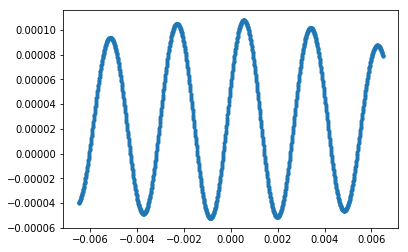

In [20]:
y = linspace(-pixwidth*ccdwidth/2,pixwidth*ccdwidth/2,ccdwidth)

plt.plot(y,E(y),".-")

/Users/dawe7269/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


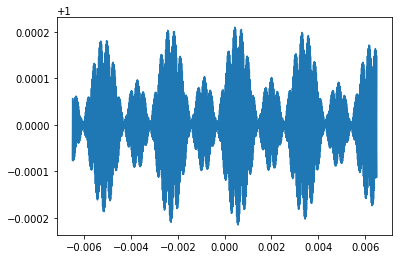

In [21]:
TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity)

(380, 440)

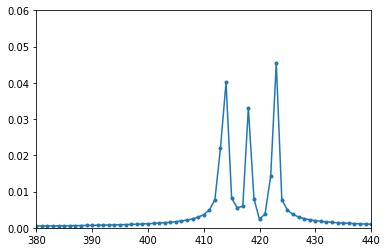

In [24]:
plt.plot(abs(fft(TotalIntensity)),".-")

plt.ylim([0,.06])

plt.xlim([380,440])


## d=0.035

In [32]:
d=0.035

/Users/dawe7269/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


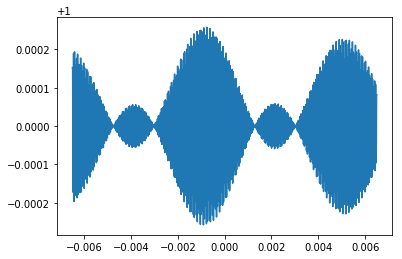

In [33]:

TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity)

(270, 350)

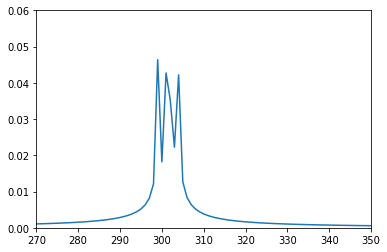

In [35]:
plt.plot(abs(fft(TotalIntensity)))

plt.ylim([0,.06])

plt.xlim([270,350])

## d=0.02

In [36]:
d=0.02

/Users/dawe7269/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


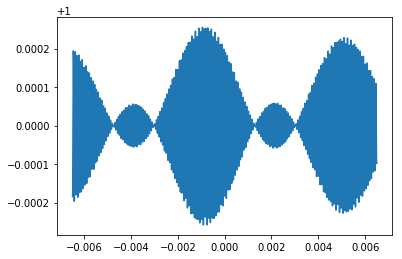

In [37]:

TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity)

(150, 200)

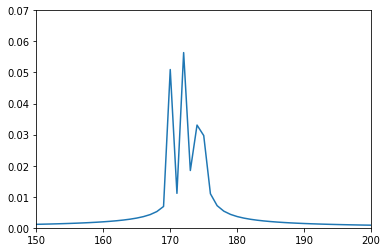

In [40]:
plt.plot(abs(fft(TotalIntensity)))

plt.ylim([0,.07])
plt.xlim([150,200])

## b=.08, a=.5 d=.03

In [41]:
b=.08*1e-3

a=.5*1e-3

d=.03

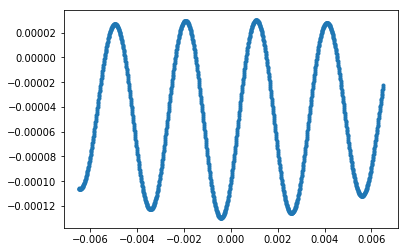

In [42]:
plt.plot(y,E(y),".-")

/Users/dawe7269/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


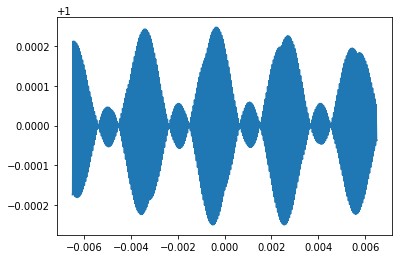

In [43]:
TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,TotalIntensity)

(220, 320)

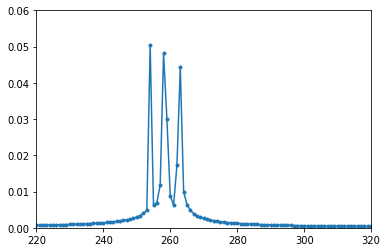

In [52]:
plt.plot(abs(fft(TotalIntensity)),".-")

plt.ylim([0,.06])
plt.xlim([220,320])

d=.01

In [63]:
d=.01

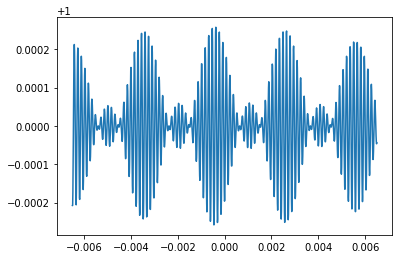

In [64]:

TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,real(TotalIntensity))

(0, 0.05)

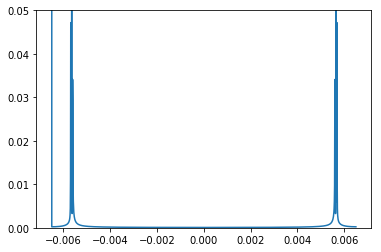

In [65]:
plt.plot(y,abs(fft(TotalIntensity)))

plt.ylim([0,.05])

d=.02

In [66]:
d=.02

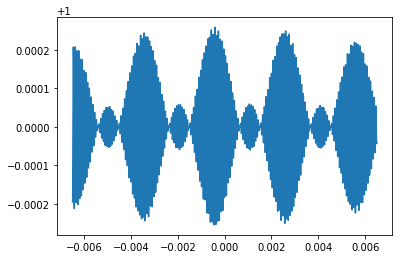

In [67]:

TotalIntensity=(E(y)+E_lo(y))*(E(y)+E_lo(y)).conj()
plt.plot(y,real(TotalIntensity))
#plt.xlim([-.002,0])

(125, 205)

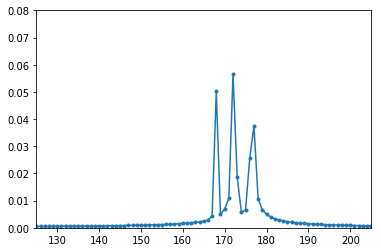

In [69]:
plt.plot(abs(fft(TotalIntensity)),".-")

plt.ylim([0,.08])

plt.xlim([125,205])

### Now, import gaussian beam function, and repeat:

In [27]:
import BeamOptics as bopt

In [28]:
d=.027

y = linspace(-.006,.006,600)

In [47]:
E_lo_gauss = bopt.gaussian_beam(0,y,L,E0=0.005,wavelambda=795e-9,w0=0.003,k=[0,k*d/L,k])

#TODO: check these beam parameters for sanity

#TODO: k value make sense?

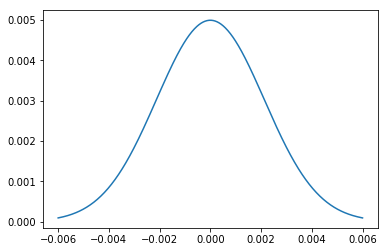

In [48]:
plt.plot(y,abs(E_lo_gauss))

In [49]:
TotalIntensity=(E(y)+E_lo_gauss) * (E(y)+E_lo_gauss).conj()

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


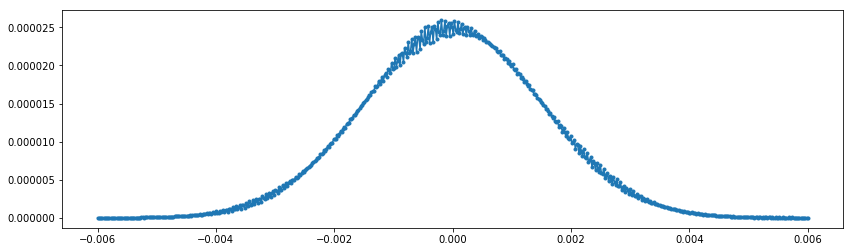

In [50]:
plt.figure(figsize=(14,4))
plt.plot(y,TotalIntensity,".-")

#plt.xlim([-.002,0])

(100, 250)

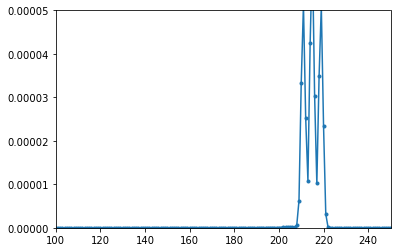

In [51]:
plt.plot(abs(fft(TotalIntensity)),".-")

plt.ylim([0,.00005]) # Had to lower the LO power quite a bit, and then zoom way in.

plt.xlim([100,250])

## Conclusions:
With the right scaling (-0.006 to 0.006) the peaks agree fairly well. Next compare to different slit sizes.

## Zernike Local Oscillator: 

In [160]:
Z_1=1

In [161]:
def Z_2(x):
    return 2*x
def Z_3(y):
    return 2*y

In [162]:
def Z_4(x,y):
    return (6**.5)*2*x*y

In [163]:
def Z_5(x,y):
    return (3**.5)*(2*x**2+2*y**2-1) 
def Z_6(x,y):
    return (6**.5)*(x**2 - y**2)

In [164]:
def Z_7(x,y):
    return (8**.5)*(3*x**2*y-y**3)
def Z_8(x,y):
    return (8**.5)*(3*x**2*y-y+3*y**3-2*y)

In [165]:
def Z_9(x,y):
    return (8**.5)*(3*x**3+3*x*y**2-2*x)
def Z_10(x,y):
    return (8**.5)*(x**3-3*x*y**2)

In [166]:
def Psi(x,y,w,Cn=[.12,.08,.018,0.039,-.275,.031,.00,.00,0.003,-.027]):
    Zsum = Cn[0]*Z_1 + Cn[1]*Z_2(x) + Cn[2]*Z_3(y) + Cn[3]*Z_4(x,y) + Cn[4]*Z_5(x,y) 
    Zsum += Cn[5]*Z_6(x,y) + Cn[6]*Z_7(x,y) + Cn[7]*Z_8(x,y) + Cn[8]*Z_9(x,y) + Cn[9]*Z_10(x,y)
    return exp(-(x**2 + y**2)/ w**2)* exp(1j*2*pi*Zsum)

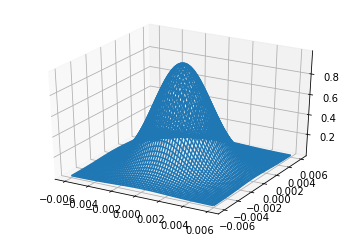

In [167]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x=linspace(-.006,.006,600)
y=linspace(-.006,.006,600)
X, Y = meshgrid(x,y)
Z=Psi(X,Y,w=.003,Cn=[.158,-.025,.025,-.007,-.143,-.008,-.006,.007,.01,-.011])
ax.plot_wireframe(X, Y, abs(Z), rstride=10, cstride=10)

In [168]:
LObeam = Z[:,300]

In [169]:
import BeamOptics as bopt

In [170]:
d=.027

y = linspace(-.006,.006,1200)

In [171]:
LObeam = bopt.gaussian_beam(0,y,L,E0=0.005,wavelambda=795e-9,w0=0.003,k=[0,k*d/L,k])


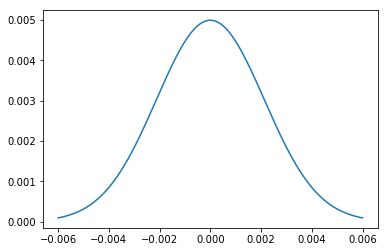

In [172]:
plt.plot(y,abs(LObeam))

In [173]:
TotalIntensity=(E(y)+LObeam) * (E(y)+LObeam).conj()

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


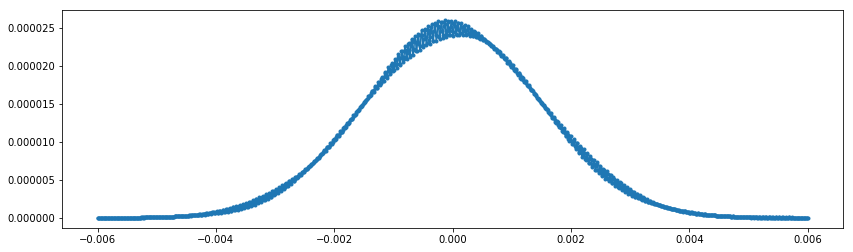

In [174]:
plt.figure(figsize=(14,4))
plt.plot(y,TotalIntensity,".-")

#plt.xlim([-.002,0])

(150, 250)

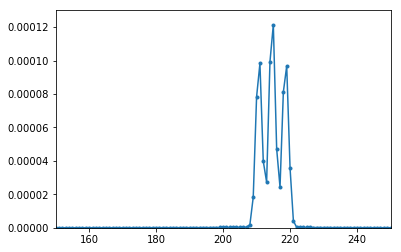

In [175]:
plt.plot(abs(fft(TotalIntensity)),".-")

plt.ylim([0,.00013]) # Had to lower the LO power quite a bit, and then zoom way in.

plt.xlim([150,250])